<a href="https://colab.research.google.com/github/theclosedbook/TensorFlow/blob/main/07_Food_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 07 Milestone Project 1:  Food Vision Big™
In the previous notebook (transfer learning part 3: scaling up) we built Food Vision mini: a transfer learning model which beat the original results of the Food101 paper with only 10% of the data.

But you might be wondering, what would happen if we used all the data?

Well, that's what we're going to find out in this notebook!

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time we've got the goal of beating DeepFood, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

Note: Top-1 accuracy means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). Top-5 accuracy means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

Food Vision Big Food Vision mini
Dataset source	TensorFlow Datasets	Preprocessed download from Kaggle
Train data	75,750 images	7,575 images
Test data	25,250 images	25,250 images
Mixed precision	Yes	No
Data loading	Performanant tf.data API	TensorFlow pre-built function
Target results	77.4% top-1 accuracy (beat DeepFood paper)	50.76% top-1 accuracy (beat Food101 paper)
Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:

Prefetching
Mixed precision training
But more on these later.

What we're going to cover
Using TensorFlow Datasets to download and explore data
Creating preprocessing function for our data
Batching & preparing datasets for modelling (making our datasets run fast)
Creating modelling callbacks
Setting up mixed precision training
Building a feature extraction model (see transfer learning part 1: feature extraction)
Fine-tuning the feature extraction model (see transfer learning part 2: fine-tuning)
Viewing training results on TensorBoard
How you should approach this notebook
You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to write more code.

We're going to be using mixed precision training.

Mixed precision training was introduced in TensorFlow 2.4.0 (a very new feature at the time of writing).

What does mixed precision training do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the TensorFlow documentation on mixed precision for more details.

For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible.

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

In [1]:
!nvidia-smi

Wed Mar  6 19:24:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Check TensorFlow version
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [3]:
# Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-06 19:24:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-06 19:24:48 (87.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Use TensorFlow Datasets to Download Data
In previous notebooks, we've downloaded our food images (from the Food101 dataset) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through TensorFlow Datasets (TFDS).

What is TensorFlow Datasets?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

Load data already in Tensors
Practice on well established datasets
Experiment with differet data loading techniques (like we're going to use in this notebook)
Experiment with new TensorFlow features quickly (such as mixed precision training)
Why not use TensorFlow Datasets?

The datasets are static (they don't change, like your real-world datasets would)
Might not be suited for your particular problem (but great for experimenting)
To begin using TensorFlow Datasets we can import it under the alias tfds.

In [5]:
# get Tensorflow datasets
import tensorflow_datasets as tfds

In [6]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is food101 in the list

True


In [7]:
# Load in the data
(train_data , test_data) , ds_info = tfds.load(name="food101",
                                               split=["train","validation"],
                                               shuffle_files=True,
                                               as_supervised=True,
                                               with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete83GJKA/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete83GJKA/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the food 101 dataset

To become one with the data, we wnat to find:
* Class names
* The shape of our input data(image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one hot encoded or are they in labelled format)
* Do the labels match up with the class names?

In [8]:
# features of food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor , label )
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training smaple
for image , label in train_one_sample:
  print(f"""
  Image Shape: {image.shape}
  Image datatype: {image.dtype}
  Target Class (tensor name); {label}
  Class name (str form) : {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target Class (tensor name); 30
  Class name (str form) : deviled_eggs
  


In [12]:
# what does our image tensor look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 28,  31,  50],
        [ 27,  30,  49],
        [ 21,  23,  44],
        ...,
        [ 17,  28,  60],
        [ 20,  30,  65],
        [ 28,  38,  73]],

       [[ 11,  14,  33],
        [ 23,  26,  45],
        [ 24,  26,  47],
        ...,
        [ 39,  50,  82],
        [ 33,  44,  76],
        [ 19,  30,  62]],

       [[ 16,  17,  37],
        [ 23,  24,  44],
        [ 19,  20,  40],
        ...,
        [ 45,  56,  86],
        [ 39,  50,  80],
        [ 36,  47,  77]],

       ...,

       [[148,  94, 117],
        [153,  99, 122],
        [153, 102, 121],
        ...,
        [ 94, 128, 166],
        [ 96, 130, 168],
        [ 96, 131, 169]],

       [[143,  89, 112],
        [151,  97, 120],
        [153, 102, 121],
        ...,
        [102, 134, 173],
        [103, 135, 174],
        [101, 135, 173]],

       [[145,  91, 114],
        [154, 100, 123],
        [158, 107, 126],
        ...,
        [105, 137, 17

In [13]:
# what are the min and max values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TF dataset

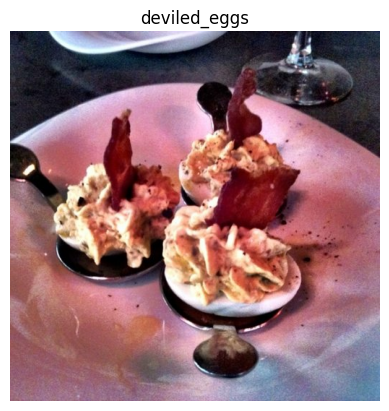

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

NN performs best when data is in acertain way (e.g. batched,normalized etc)
What we know about our data

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:

* in `uint8` datatype
* Comprised of all different size tensors (different size images)
* Not scaled the pixel value is b/w 0 & 255

What we know models like:

* Data in `float32` dtype(or for mixed precision `float16` & `float32`)
* For batches, Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values b/w 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architecture have resscaling built-in)

This means our function needs to:

1. Reshape our images to all the same size
2. Convert the dtype of our images tensors from `uint8` to `float32`

In [15]:
# Make a function for preprocessing images
def preprocess_img(image,label,img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [image_shape,image_shape,color_chanel]
  """
  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32) , label


In [16]:
# preprocess a single img and check the outputs
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[28 31 50]
  [27 30 49]
  [21 23 44]
  ...
  [17 28 60]
  [20 30 65]
  [28 38 73]]

 [[11 14 33]
  [23 26 45]
  [24 26 47]
  ...
  [39 50 82]
  [33 44 76]
  [19 30 62]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[21.801022 24.801022 43.80102 ]
  [17.7551   19.7551   40.755104]
  [16.16837  18.16837  41.16837 ]
  ...
  [37.61732  46.831585 75.964294]
  [30.214298 41.2143   72.02044 ]
  [26.163052 36.80591  69.877335]]

 [[22.091837 23.091837 43.09184 ]
  [10.974489 11.974489 31.97449 ]
  [16.112244 17.112244 38.112244]
  ...
  [45.48988  57.48988  81.20421 ]
  [42.413116 54.34169  80.49475 ]
  [33.551304 45.479874 71.76559 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


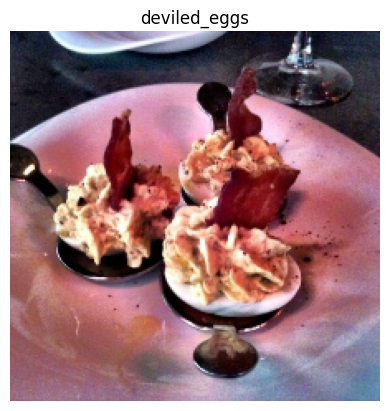

In [17]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets
Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the tf.data API.

📖 Resource: For loading data in the most performant way possible, see the TensorFlow docuemntation on Better performance with the tf.data API.

Specifically, we're going to be using:

map() - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)
prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
Extra: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)
Things to note:

Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our preprocess_img() function)
shuffle() keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
For methods with the num_parallel_calls parameter available (such as map()), setting it tonum_parallel_calls=tf.data.AUTOTUNE will parallelize preprocessing and significantly improve speed
Can't use cache() unless your dataset can fit in memory
Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset


In [18]:
# Map preprocessing function to training data (and parllelize)
train_data = train_data.map(map_func = preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (laod it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test_data
test_data = test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data , test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modellling callbacks

We're going to create a couple of ccallbacks to help us while our models trains:

* TensorBoard callback to log training results (so we can visualize them later if needed)
* ModelCheckpoint callback to save our models progress after feature extraction

In [20]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a model checkpoint callback to save a models progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)


## Set up mixed precision training

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [25]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


## Build featire extracttion model

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)
Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's "mixed_float16").

We can check this by iterating through our model's layers and printing layer attributes such as dtype and dtype_policy.

In [27]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

layer.name (str) : a layer's human-readable name, can be defined by the name parameter on construction
layer.trainable (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
layer.dtype : the data type a layer stores its variables in
layer.dtype_policy : the data type a layer computes in
🔑 Note: A layer can have a dtype of float32 and a dtype policy of "mixed_float16" because it stores its variables (weights & biases) in float32 (more numerically stable), however it computes in float16 (faster).

In [28]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

## Fit the feature extraction model
Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [29]:
# Fit the feature extraction model
history_101 = model.fit(train_data,
                        epochs=3,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15* len(train_data)),
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                               experiment_name="efficientNetb0"),
                                   model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientNetb0/20240306-203637
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7180 - accuracy: 0.5814

2368/2368 [==============================] - 216s 85ms/step - loss: 1.7180 - accuracy: 0.5814 - val_loss: 1.1347 - val_accuracy: 0.6985
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1998 - accuracy: 0.6889

2368/2368 [==============================] - 181s 76ms/step - loss: 1.1998 - accuracy: 0.6889 - val_loss: 1.0385 - val_accuracy: 0.7148
Epoch 3/3
1382/2368 [================>.............] - ETA: 1:06 - loss: 1.0516 - accuracy: 0.7253

KeyboardInterrupt: 